In [ ]:
import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, MultiPoint
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np

# Configurações de visualização
pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (14, 10)

# Conexão com o banco de dados
DB_USER = "myuser"
DB_PASS = "mypassword"
DB_HOST = "localhost" 
DB_PORT = "5432"
DB_NAME = "bus_predictions"
DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DATABASE_URL)

print("Ambiente do Notebook pronto.")

Ambiente do Notebook pronto.


In [2]:
linha_alvo = 371
data_inicio = '2024-04-25'
data_fim = '2024-04-28'
sql_query = f"""
    SELECT * FROM gps_data 
    WHERE linha = '{linha_alvo}' 
    AND datahoraservidor >= '{data_inicio}' 
    AND datahoraservidor < '{data_fim}'
"""
gdf = gpd.read_postgis(sql_query, engine, geom_col='geom')

## Limpeza e Validação dos Dados Carregados

In [ ]:
# Garante que os dados estão no formato correto e ordena
gdf['datahoraservidor'] = pd.to_datetime(gdf['datahoraservidor'])
gdf.sort_values(by=['ordem', 'datahoraservidor'], inplace=True)

# Filtra pelo horário de operação (08:00 até 22:59)
gdf['hora'] = gdf['datahoraservidor'].dt.hour
gdf_operacao = gdf[gdf['hora'].between(8, 22)].copy()

# Remove velocidades irreais e duplicatas
gdf_operacao = gdf_operacao[gdf_operacao['velocidade'] <= 120]
gdf_operacao.drop_duplicates(inplace=True)

print(f"Após a limpeza, restaram {len(gdf_operacao)} registros para a análise.")
display(gdf_operacao.head())

Após a limpeza, restaram 212713 registros para a análise.


,id,ordem,latitude,longitude,datahora,velocidade,linha,datahoraenvio,datahoraservidor,geom,hora
8751,1577204,B51539,-22.87856,-43.35818,2024-04-25 09:09:35,22,371,2024-04-25 09:09:48,2024-04-25 09:10:05,POINT (-43.35818 -22.87856),9
8792,1580197,B51539,-22.87975,-43.35567,2024-04-25 09:10:05,40,371,2024-04-25 09:10:10,2024-04-25 09:10:35,POINT (-43.35567 -22.87975),9
9019,1584723,B51539,-22.88116,-43.35225,2024-04-25 09:10:35,42,371,2024-04-25 09:10:41,2024-04-25 09:11:06,POINT (-43.35225 -22.88116),9
9055,1589265,B51539,-22.88228,-43.34925,2024-04-25 09:11:05,31,371,2024-04-25 09:11:13,2024-04-25 09:11:37,POINT (-43.34925 -22.88228),9
9142,1593818,B51539,-22.88260,-43.34834,2024-04-25 09:11:35,9,371,2024-04-25 09:11:45,2024-04-25 09:12:07,POINT (-43.34834 -22.8826),9


## Identificar Pontos do Onibus -> Separar Ida e Volta -> Contruir Caminhos

Iniciando a identificação de terminais...
Encontradas 396 paradas longas (potenciais pontos terminais).
DBSCAN encontrou 45 clusters de terminais.
Terminais A e B definidos com sucesso.

Iniciando a separação de sentidos...


c:\Users\gupes\REPOS\datamining\Data-Mining\datamining\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Coluna 'sentido' criada com sucesso.
sentido
1.0    112884
0.0     99433
NaN       396
Name: count, dtype: int64

Construindo trajeto para o Sentido: 1.0...


C:\Users\gupes\AppData\Local\Temp\ipykernel_16568\4163481512.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_media_A = pontos_sentido.head(10).geometry.distance(terminal_A).mean()
C:\Users\gupes\AppData\Local\Temp\ipykernel_16568\4163481512.py:56: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_media_B = pontos_sentido.head(10).geometry.distance(terminal_B).mean()
C:\Users\gupes\AppData\Local\Temp\ipykernel_16568\4163481512.py:59: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pontos_sentido['distancia_partida'] = pontos_sentido.geometry.distance(terminal_par

  - Trajeto para o sentido 1.0 criado com sucesso.

Construindo trajeto para o Sentido: 0.0...


C:\Users\gupes\AppData\Local\Temp\ipykernel_16568\4163481512.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_media_A = pontos_sentido.head(10).geometry.distance(terminal_A).mean()
C:\Users\gupes\AppData\Local\Temp\ipykernel_16568\4163481512.py:56: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_media_B = pontos_sentido.head(10).geometry.distance(terminal_B).mean()
C:\Users\gupes\AppData\Local\Temp\ipykernel_16568\4163481512.py:59: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pontos_sentido['distancia_partida'] = pontos_sentido.geometry.distance(terminal_par

  - Trajeto para o sentido 0.0 criado com sucesso.


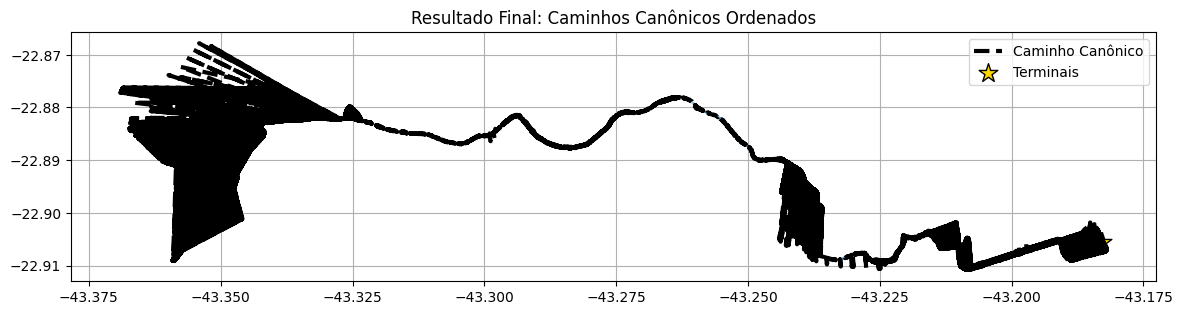

In [ ]:
# Identificar Pontos Terminais 
print("Iniciando a identificação de terminais...")
paradas = gdf_operacao[gdf_operacao['velocidade'] == 0].copy()
paradas['tempo_diff_min'] = paradas.groupby('ordem')['datahoraservidor'].diff().dt.total_seconds() / 60
paradas_terminais = paradas[paradas['tempo_diff_min'].between(10, 30)]
print(f"Encontradas {len(paradas_terminais)} paradas longas (potenciais pontos terminais).")

# Seleção Robusta dos 2 Terminais Principais 
terminal_A, terminal_B = None, None
if len(paradas_terminais) >= 2:
    clustering = DBSCAN(eps=0.001, min_samples=2).fit(paradas_terminais[['latitude', 'longitude']])
    paradas_terminais['terminal_cluster'] = clustering.labels_
    
    terminais_encontrados = {
        label: MultiPoint(paradas_terminais[paradas_terminais['terminal_cluster'] == label].geometry.tolist()).centroid
        for label in paradas_terminais['terminal_cluster'].unique() if label != -1
    }
    print(f"DBSCAN encontrou {len(terminais_encontrados)} clusters de terminais.")
    
    if len(terminais_encontrados) >= 2:
        if len(terminais_encontrados) == 2:
            terminal_A, terminal_B = list(terminais_encontrados.values())
        else:
            pontos_terminais = list(terminais_encontrados.values())
            max_dist, melhor_par = 0, (None, None)
            for p1, p2 in combinations(pontos_terminais, 2):
                dist = p1.distance(p2)
                if dist > max_dist:
                    max_dist, melhor_par = dist, (p1, p2)
            terminal_A, terminal_B = melhor_par
        print("Terminais A e B definidos com sucesso.")

if not (terminal_A and terminal_B):
    print("AVISO: Não foi possível definir os dois terminais principais. A criação da rota pode falhar ou ser imprecisa.")
else:
    # Separar os Sentidos (Ida e Volta) 
    print("\nIniciando a separação de sentidos...")
    pontos_em_movimento_idx = gdf_operacao.index.difference(paradas_terminais.index)
    pontos_em_movimento = gdf_operacao.loc[pontos_em_movimento_idx].copy()

    if len(pontos_em_movimento) > 2:
        kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(pontos_em_movimento[['latitude', 'longitude']])
        gdf_operacao.loc[pontos_em_movimento.index, 'sentido'] = labels
        print("Coluna 'sentido' criada com sucesso.")
        print(gdf_operacao['sentido'].value_counts(dropna=False))
    
        # Construir os Caminhos Canônicos 
        trajetos_finais = {}
        for sentido_id in gdf_operacao['sentido'].dropna().unique():
            print(f"\nConstruindo trajeto para o Sentido: {sentido_id}...")
            pontos_sentido = gdf_operacao[gdf_operacao['sentido'] == sentido_id].copy()
            if len(pontos_sentido) < 2: continue
            
            dist_media_A = pontos_sentido.head(10).geometry.distance(terminal_A).mean()
            dist_media_B = pontos_sentido.head(10).geometry.distance(terminal_B).mean()
            terminal_partida = terminal_A if dist_media_A < dist_media_B else terminal_B
            
            pontos_sentido['distancia_partida'] = pontos_sentido.geometry.distance(terminal_partida)
            pontos_ordenados = pontos_sentido.sort_values('distancia_partida')
            
            linha_ordenada = LineString(pontos_ordenados.geometry.tolist())
            trajeto_simplificado = linha_ordenada.simplify(tolerance=0.0001, preserve_topology=True)
            trajetos_finais[sentido_id] = trajeto_simplificado
            print(f"  - Trajeto para o sentido {sentido_id} criado com sucesso.")
            
        # Visualização Final 
        fig, ax = plt.subplots(1, 1, figsize=(14, 10))
        if not gdf_operacao[gdf_operacao['sentido'].notna()].empty:
            amostra = gdf_operacao.dropna(subset=['sentido']).sample(min(5000, len(gdf_operacao.dropna(subset=['sentido']))))
            amostra.plot(ax=ax, column='sentido', categorical=True, markersize=1, alpha=0.2, legend=True)
        if trajetos_finais:
            gpd.GeoSeries(trajetos_finais).plot(ax=ax, color='black', linewidth=3, linestyle='--', label='Caminho Canônico')
        gpd.GeoSeries([terminal_A, terminal_B]).plot(ax=ax, color='gold', marker='*', markersize=200, edgecolor='black', label='Terminais')
        plt.title("Resultado Final: Caminhos Canônicos Ordenados")
        plt.legend()
        plt.grid(True)
        plt.show()

## Calcular distâncias

In [ ]:
def calcular_distancia_no_trajeto(row, trajetos_dict):
    # Pega a geometria do ponto e o seu sentido
    ponto = row['geom']
    sentido = row['sentido']
    
    # Seleciona o trajeto correto (ida ou volta)
    trajeto = trajetos_dict.get(sentido)
    
    if trajeto:
        return trajeto.project(ponto)
    
    return None

# Aplica a função para criar a nova coluna 'distancia_trajeto'
# Usamos apenas os dados que têm um sentido definido
gdf_com_sentido = gdf_operacao.dropna(subset=['sentido']).copy()
gdf_com_sentido['distancia_trajeto'] = gdf_com_sentido.apply(
    lambda row: calcular_distancia_no_trajeto(row, trajetos_finais),
    axis=1
)

print("Coluna 'distancia_trajeto' criada com sucesso.")
display(gdf_com_sentido[['ordem', 'datahoraservidor', 'sentido', 'distancia_trajeto']].head())

Coluna 'distancia_trajeto' criada com sucesso.


,ordem,datahoraservidor,sentido,distancia_trajeto
8751,B51539,2024-04-25 09:10:05,1.0,93.307094
8792,B51539,2024-04-25 09:10:35,1.0,92.037403
9019,B51539,2024-04-25 09:11:06,1.0,91.172236
9055,B51539,2024-04-25 09:11:37,1.0,90.782437
9142,B51539,2024-04-25 09:12:07,1.0,90.710303


## Features de Tempo

In [ ]:
# Hora do dia (formato 24h, de 0 a 23)
# Ajuda o modelo a entender padrões gerais como "manhã", "tarde", "noite"
gdf_com_sentido['hora_do_dia'] = gdf_com_sentido['datahoraservidor'].dt.hour

# Dia da semana
# Essencial para diferenciar dias úteis de fins de semana
# Onde: Segunda-feira=0, Terça-feira=1, ..., Domingo=6
gdf_com_sentido['dia_da_semana'] = gdf_com_sentido['datahoraservidor'].dt.dayofweek

# Minuto do dia (de 0 a 1439)
# Uma feature contínua que representa o fluxo do dia
gdf_com_sentido['minuto_do_dia'] = gdf_com_sentido['datahoraservidor'].dt.hour * 60 + gdf_com_sentido['datahoraservidor'].dt.minute

# Fim de semana (Booleano/Binário)
gdf_com_sentido['fim_de_semana'] = (gdf_com_sentido['dia_da_semana'] >= 5).astype(int)


# Verificação 
print("Features de tempo criadas com sucesso:")

display(
    gdf_com_sentido[[
        'datahoraservidor',
        'hora_do_dia',
        'minuto_do_dia',
        'dia_da_semana',
        'fim_de_semana'
    ]].head()
)

Features de tempo criadas com sucesso:


,datahoraservidor,hora_do_dia,minuto_do_dia,dia_da_semana,fim_de_semana
8751,2024-04-25 09:10:05,9,550,3,0
8792,2024-04-25 09:10:35,9,550,3,0
9019,2024-04-25 09:11:06,9,551,3,0
9055,2024-04-25 09:11:37,9,551,3,0
9142,2024-04-25 09:12:07,9,552,3,0


## Feature Velocidade

In [ ]:
# É crucial que os dados estejam ordenados por ônibus e depois por tempo
# para que a média móvel seja calculada corretamente.
gdf_com_sentido_sorted = gdf_com_sentido.sort_values(by=['ordem', 'datahoraservidor'])

# --- Criação da Feature ---

# Usamos groupby('ordem') para garantir que a média seja calculada apenas com os dados do mesmo ônibus
rolling_mean = gdf_com_sentido_sorted.groupby('ordem')['velocidade'].rolling(window=5, min_periods=1).mean()

# O resultado de groupby().rolling() tem um índice múltiplo.
rolling_mean = rolling_mean.reset_index(level=0, drop=True)

# Atribui a nova coluna ao nosso dataframe principal
gdf_com_sentido['velocidade_recente_media'] = rolling_mean

# Os primeiros registros de cada ônibus terão valores Nulos (NaN), pois não há 5 pontos anteriores.
gdf_com_sentido['velocidade_recente_media'].fillna(method='ffill', inplace=True)
gdf_com_sentido['velocidade_recente_media'].fillna(0, inplace=True) # Preenche qualquer NaN restante com 0


# Verificação
print("Feature 'velocidade_recente_media' criada com sucesso.")
print("Note como o valor é uma média suavizada da coluna 'velocidade'.")

# Mostra as colunas relevantes para comparar
display(
    gdf_com_sentido[[
        'ordem',
        'datahoraservidor',
        'velocidade',
        'velocidade_recente_media'
    ]].head(10) # Mostra as 10 primeiras linhas
)

Feature 'velocidade_recente_media' criada com sucesso.
Note como o valor é uma média suavizada da coluna 'velocidade'.


C:\Users\gupes\AppData\Local\Temp\ipykernel_16568\338762105.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf_com_sentido['velocidade_recente_media'].fillna(method='ffill', inplace=True)
C:\Users\gupes\AppData\Local\Temp\ipykernel_16568\338762105.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdf_com_sentido['velocidade_recente_media'].fillna(method='ffill', inplace=True)
C:\Users\gupes\AppData\Local\Temp\ipykernel_16568\33876

,ordem,datahoraservidor,velocidade,velocidade_recente_media
8751,B51539,2024-04-25 09:10:05,22,22.000000
8792,B51539,2024-04-25 09:10:35,40,31.000000
9019,B51539,2024-04-25 09:11:06,42,34.666667
9055,B51539,2024-04-25 09:11:37,31,33.750000
9142,B51539,2024-04-25 09:12:07,9,28.800000
8834,B51539,2024-04-25 09:12:38,20,28.400000
9182,B51539,2024-04-25 09:13:09,0,20.400000
8887,B51539,2024-04-25 09:13:40,27,17.400000
148172,B51566,2024-04-26 16:57:39,22,22.000000
148443,B51566,2024-04-26 16:58:40,22,22.000000


## Aceleração

In [8]:
# Garante a ordem cronológica por ônibus
gdf_sorted = gdf_com_sentido.sort_values(by=['ordem', 'datahoraservidor'])

# .diff() calcula a diferença para a linha anterior
gdf_com_sentido['aceleracao'] = gdf_sorted.groupby('ordem')['velocidade'].diff().fillna(0)

## Desvio Padrão da Velocidade

In [9]:
# Reutiliza o gdf_sorted e o groupby
rolling_std = gdf_sorted.groupby('ordem')['velocidade'].rolling(window=5, min_periods=1).std()
rolling_std = rolling_std.reset_index(level=0, drop=True)
gdf_com_sentido['velocidade_std_recente'] = rolling_std.fillna(0)

## Rota e Geometria

In [10]:
# Primeiro, calcula o comprimento total de cada trajeto
comprimento_trajetos = {sentido: trajeto.length for sentido, trajeto in trajetos_finais.items()}

# Depois, calcula o percentual
gdf_com_sentido['percentual_trajeto'] = gdf_com_sentido.apply(
    lambda row: row['distancia_trajeto'] / comprimento_trajetos.get(row['sentido'], 1) if comprimento_trajetos.get(row['sentido']) else 0,
    axis=1
)

## Distância do Ponto Final

In [11]:
gdf_com_sentido['distancia_ate_final'] = gdf_com_sentido.apply(
    lambda row: comprimento_trajetos.get(row['sentido'], 0) - row['distancia_trajeto'],
    axis=1
)

## Tempo Cíclico

In [ ]:
# Para hora do dia (ciclo de 24h)
gdf_com_sentido['hora_sin'] = np.sin(2 * np.pi * gdf_com_sentido['hora_do_dia']/24.0)
gdf_com_sentido['hora_cos'] = np.cos(2 * np.pi * gdf_com_sentido['hora_do_dia']/24.0)

# Para dia da semana (ciclo de 7 dias)
gdf_com_sentido['dia_semana_sin'] = np.sin(2 * np.pi * gdf_com_sentido['dia_da_semana']/7.0)
gdf_com_sentido['dia_semana_cos'] = np.cos(2 * np.pi * gdf_com_sentido['dia_da_semana']/7.0)

# hora_sin' e 'hora_cos' no lugar de 'hora_do_dia'.